**2 задание (до 28.10 включительно)**
- Берем данные, которые использовали для первого задания;
- Пробуем в нескольких вариантах фич-экстракторы (tsfresh, tsfel) - были в лекции;
- Применяем k-means (нужно передать feature matrix на вход k-means);
- Визуализируем результат, пишем небольшой 5-10 предложений сравнительный анализ k-means с и без фич экстрактора в отдельной секции Юпитер-тетрадки (режим текста). Для тех, кто не хочет пользоваться Юпитером/Колабом, можно сгенерировать pdf или html.

-----

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf 
import datetime
import  matplotlib.pyplot as plt 
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler,  MinMaxScaler

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans

from tqdm.autonotebook import tqdm

%matplotlib inline

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_9904\3536967894.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import os
from pathlib import Path
import glob

In [3]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load data

In [5]:
trending_list = ['PYPL', 'AI', 'ETH-USD', 'ZM', 'AMGN', 'LUNA1-USD', 'KO', 'PLUG', 'ZIM', 'ADBE', 'WBA', 'ABBV']
most_actives_list = ['AAPL', 'AMD', 'VALE', 'CCL', 'TSLA', 'NVDA', 'F', 'AMZN',  'T', 'CS', 'NIO', 'BBD', 'INTC', 'BAC', 'ITUB', 'DKNG', 'MSFT', 'AAL', 'PCG', 'ABEV',  'META', 'MPW', 'RIG', 'TWTR', 'VZ']
gainers_list = ['BDDDY', 'WXIBF', 'CANO', 'FBBPF', 'MSGS', 'FNMAL', 'STOSF', 'DXCM', 'WXXWY', 'FMCCS', 'ATCO']
losers_list = ['AMD', 'HKD', 'LAC', 'ACAD', 'LNTH', 'MRVL', 'LEVI', 'LAZR', 'APE', 'RBLX', 'SYNA', 'NTLA', 'CVS', 'SPT', 'CFLT', 'SCRYY', 'AFRM', 'JTKWY',  'GDS', 'YMM', 'ADDDF', 'SHOP', 'COIN', 'CERE']
crypto_list = ['BTC-USD','ETH-USD','USDT-USD','USDC-USD','BNB-USD','XRP-USD','BUSD-USD', 'SOL-USD','DOGE-USD','MATIC-USD','DOT-USD','DAI-USD', 'WTRX-USD','SHIB-USD','HEX-USD','TRX-USD','UNI1-USD','AVAX-USD',  'WBTC-USD', 'STETH-USD', 'YOUC-USD', 'LEO-USD', 'LTC-USD', 'ATOM-USD']

list_all_tickers = [trending_list, most_actives_list, gainers_list, losers_list, crypto_list]

In [6]:
trending = pd.DataFrame(columns=trending_list)
for ticker in trending_list:
  trending[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

most_actives_list = pd.DataFrame(columns=most_actives_list)
for ticker in most_actives_list:
  most_actives_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

gainers_list = pd.DataFrame(columns=gainers_list)
for ticker in gainers_list:
  gainers_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

losers_list = pd.DataFrame(columns=losers_list)
for ticker in losers_list:
  losers_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

crypto_list = pd.DataFrame(columns=crypto_list)
for ticker in losers_list:
  crypto_list[ticker] = yf.download(ticker, start = '2021-09-01', end = '2022-09-30')['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
trending.reset_index(inplace=True)
crypto_list.reset_index(inplace=True)
gainers_list.reset_index(inplace=True)
losers_list.reset_index(inplace=True)
most_actives_list.reset_index(inplace=True)

In [8]:
# Соединяем все в один датафрейм
df_aux = [trending.T, crypto_list.T, losers_list.T, gainers_list.T, most_actives_list.T]
df = pd.concat(df_aux)

In [9]:
df.drop(df.index[[0, 1]], inplace = True)

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
AI,53.110001,47.669998,50.610001,51.470001,50.599998,50.639999,50.02,49.049999,48.5,49.68,...,14.03,14.03,13.44,13.35,13.14,13.15,12.77,12.93,12.96,12.34
ETH-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZM,290.859985,295.089996,298.290009,299.959991,293.600006,295.859985,301.5,290.23999,281.440002,279.119995,...,78.68,78.32,77.089996,75.940002,74.540001,74.449997,73.330002,74.260002,75.889999,74.470001
AMGN,223.350006,225.960007,226.369995,221.339996,220.869995,215.580002,213.75,216.720001,216.039993,218.130005,...,231.139999,230.759995,227.710007,224.460007,227.75,226.970001,226.869995,225.990005,230.979996,228.410004
LUNA1-USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
META,382.049988,375.279999,376.26001,382.179993,377.570007,378.0,378.690002,376.51001,376.529999,373.920013,...,146.289993,148.020004,146.089996,142.119995,142.820007,140.410004,136.369995,134.399994,141.610001,136.410004
MPW,20.99,21.57,21.65,21.549999,21.92,21.559999,21.059999,20.84,20.59,20.209999,...,13.8,13.52,13.14,12.98,12.91,12.48,12.02,11.93,12.03,11.44
RIG,3.48,3.77,3.71,3.77,3.53,3.57,3.49,3.63,3.53,3.64,...,3.03,2.94,2.73,2.68,2.55,2.36,2.39,2.48,2.73,2.48
TWTR,65.550003,64.599998,64.660004,64.980003,62.27,62.459999,61.560001,59.66,60.189999,61.84,...,41.450001,41.66,41.68,41.27,41.400002,41.580002,41.52,42.09,43.25,42.740002


In [11]:
# Избавляемся от NaN значений в данных
df.dropna(how='any', inplace = True)

In [12]:
df.isna().values.any()

False

In [13]:
# Создаем новую колонку с shortName
df['shortName'] = df.index
df

,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,271,shortName
AI,53.110001,47.669998,50.610001,51.470001,50.599998,50.639999,50.02,49.049999,48.5,49.68,...,14.03,13.44,13.35,13.14,13.15,12.77,12.93,12.96,12.34,AI
ZM,290.859985,295.089996,298.290009,299.959991,293.600006,295.859985,301.5,290.23999,281.440002,279.119995,...,78.32,77.089996,75.940002,74.540001,74.449997,73.330002,74.260002,75.889999,74.470001,ZM
AMGN,223.350006,225.960007,226.369995,221.339996,220.869995,215.580002,213.75,216.720001,216.039993,218.130005,...,230.759995,227.710007,224.460007,227.75,226.970001,226.869995,225.990005,230.979996,228.410004,AMGN
KO,56.689999,56.77,56.73,55.669998,56.419998,55.860001,55.610001,56.07,55.689999,55.880001,...,59.990002,59.900002,59.400002,59.259998,58.599998,57.869999,56.380001,56.98,56.57,KO
PLUG,26.93,27.15,26.4,26.799999,25.25,25.26,24.16,24.209999,24.66,24.629999,...,27.709999,26.0,25.52,23.940001,22.629999,21.690001,21.85,22.5,21.040001,PLUG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
META,382.049988,375.279999,376.26001,382.179993,377.570007,378.0,378.690002,376.51001,376.529999,373.920013,...,148.020004,146.089996,142.119995,142.820007,140.410004,136.369995,134.399994,141.610001,136.410004,META
MPW,20.99,21.57,21.65,21.549999,21.92,21.559999,21.059999,20.84,20.59,20.209999,...,13.52,13.14,12.98,12.91,12.48,12.02,11.93,12.03,11.44,MPW
RIG,3.48,3.77,3.71,3.77,3.53,3.57,3.49,3.63,3.53,3.64,...,2.94,2.73,2.68,2.55,2.36,2.39,2.48,2.73,2.48,RIG
TWTR,65.550003,64.599998,64.660004,64.980003,62.27,62.459999,61.560001,59.66,60.189999,61.84,...,41.66,41.68,41.27,41.400002,41.580002,41.52,42.09,43.25,42.740002,TWTR


# Scaling everything

In [14]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:,:-1].T).T

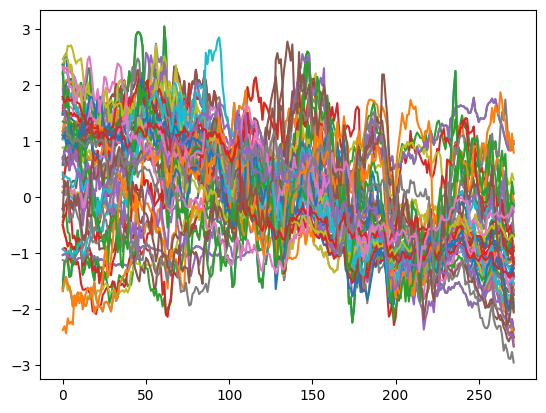

In [15]:
plt.plot(data_scaled.T)
plt.show()

In [16]:
data_scaled.size

21216

In [23]:
data_scaled_df = pd.DataFrame(data_scaled, index=df.index, columns=df.iloc[:,:-1].columns)

# Feature extraction

In [24]:
# Возьмем минимальный набор признаков, которые можно извлечь
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [26]:
# Добавим признаки для построения линейного тренда внутри временного ряда, нахождения значения коэффициента R2, intercept, slope, и p-value
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time

{'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}], 'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [27]:
settings_efficient = settings.EfficientFCParameters()

In [28]:
# Самый широкий набор признаков
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

76

Возьмем эффективный список параметров и построим с его помощью новое признаковое пространство

In [29]:
data_long = pd.DataFrame({0: data_scaled_df.values.flatten(),
                          1: np.arange(data_scaled_df.shape[0]).repeat(data_scaled_df.shape[1])})
print(data_long.shape)
data_long.head()

(21216, 2)


,0,1
0,2.240699,0
1,1.770823,0
2,2.024763,0
3,2.099045,0
4,2.023899,0


Извлекаем признаки при помощи extract_features, указав в качестве параметров для извлечения эффективный список

In [30]:
X_efficient = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


In [31]:
X_comprehensive = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_comprehensive)

Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


In [32]:
X_time = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_time)

Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


# Use k-means:

In [33]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

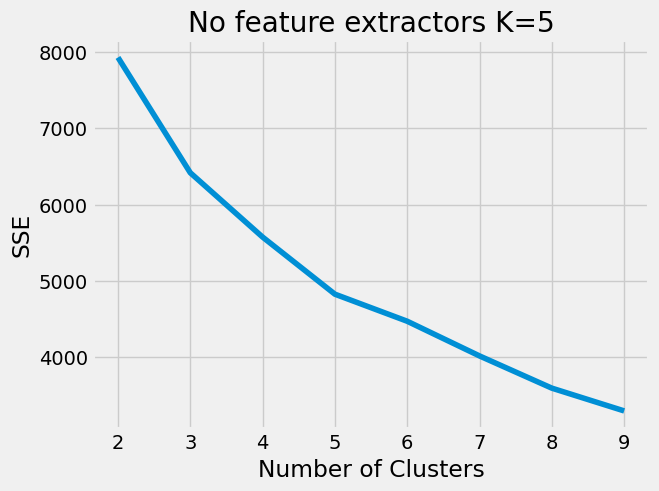

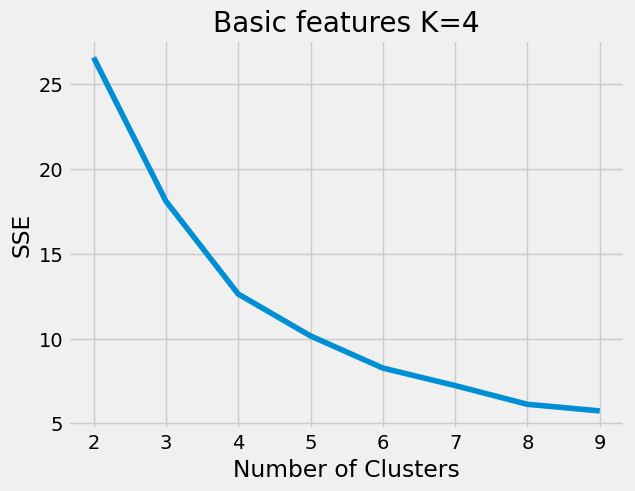

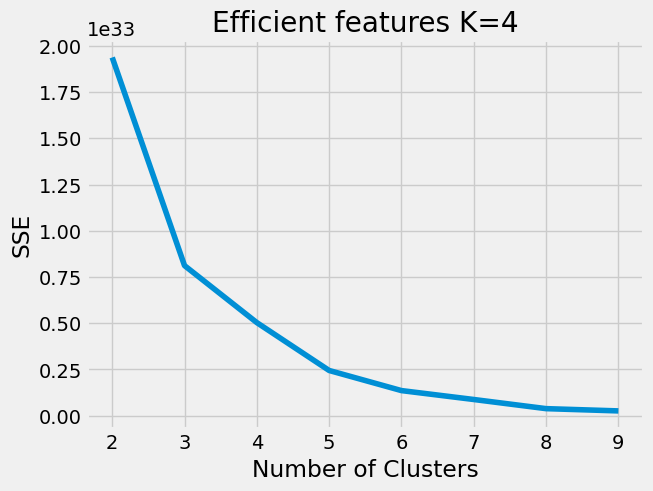

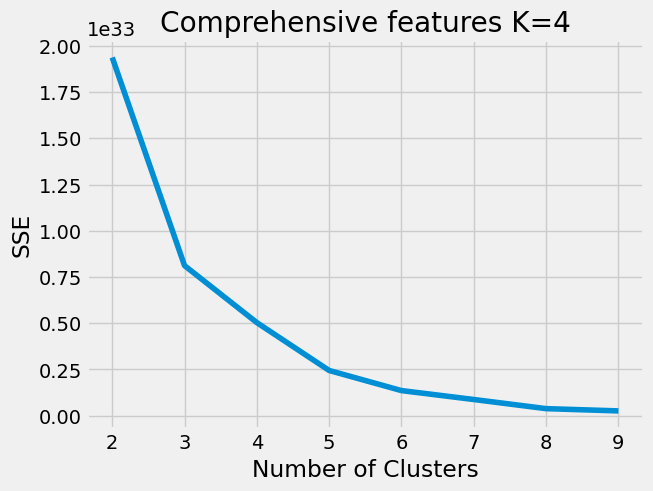

In [35]:
for feature_matrix, name in zip([data_scaled_df, X_time, X_efficient, X_comprehensive], ['No feature extractors', 'Basic features', 'Efficient features', 'Comprehensive features']):
    sse = []
    for k in range(2, 10):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(feature_matrix)
      sse.append(kmeans.inertia_)
    
    kl = KneeLocator(
      range(2, 10), sse, curve="convex", direction="decreasing"
      )
    
    plt.style.use("fivethirtyeight")
    plt.title(name + f" K={kl.elbow}")
    plt.plot(range(2, 10), sse)
    plt.xticks(range(2, 10))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

# Comparison

Выберем для анализа Efficient feature extractor и матрицу данных без применения экстрактора

In [46]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(data_scaled_df)

KMeans(init='random', n_clusters=5, random_state=42)

In [47]:
KMeans(init='random', n_clusters=5, random_state=42)

KMeans(init='random', n_clusters=5, random_state=42)

In [48]:
fe_kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
fe_kmeans.fit(X_efficient)

KMeans(init='random', n_clusters=4, random_state=42)

In [49]:
KMeans(init='random', n_clusters=4, random_state=42)

KMeans(init='random', n_clusters=4, random_state=42)

Посмотрим, какие валюты в каждом кластере.
Без feature extractor:

In [50]:
data_scaled_df.index[kmeans.labels_ == 0]

Index(['WBA', 'AMD', 'ACAD', 'MRVL', 'LAZR', 'SYNA', 'SCRYY', 'AMD', 'ACAD',
       'MRVL', 'LAZR', 'SYNA', 'SCRYY', 'AMD', 'NVDA', 'F', 'INTC', 'BAC',
       'MSFT', 'MPW', 'VZ'],
      dtype='object')

In [51]:
data_scaled_df.index[kmeans.labels_ == 1]

Index(['AI', 'ZM', 'ADBE', 'LEVI', 'RBLX', 'NTLA', 'SPT', 'CFLT', 'AFRM',
       'JTKWY', 'GDS', 'YMM', 'ADDDF', 'SHOP', 'COIN', 'CERE', 'LEVI', 'RBLX',
       'NTLA', 'SPT', 'CFLT', 'AFRM', 'JTKWY', 'GDS', 'YMM', 'ADDDF', 'SHOP',
       'COIN', 'CERE', 'CCL', 'AMZN', 'CS', 'NIO', 'DKNG', 'AAL', 'META',
       'TWTR'],
      dtype='object')

In [52]:
data_scaled_df.index[kmeans.labels_ == 2]

Index(['AMGN', 'KO', 'ABBV', 'LNTH', 'CVS', 'LNTH', 'CVS', 'ITUB'], dtype='object')

In [53]:
data_scaled_df.index[kmeans.labels_ == 3]

Index(['ZIM', 'VALE', 'T', 'BBD', 'RIG'], dtype='object')

In [54]:
data_scaled_df.index[kmeans.labels_ == 4]

Index(['PLUG', 'LAC', 'LAC', 'AAPL', 'TSLA', 'PCG', 'ABEV'], dtype='object')

С feature extractor:

In [55]:
data_scaled_df.index[fe_kmeans.labels_ == 0]

Index(['AMGN', 'KO', 'WBA', 'SHOP', 'CERE', 'SHOP', 'CERE', 'AAPL', 'CCL',
       'TSLA', 'AMZN', 'BBD', 'BAC', 'MSFT', 'PCG', 'ABEV', 'VZ'],
      dtype='object')

In [56]:
data_scaled_df.index[fe_kmeans.labels_ == 1]

Index(['AMD', 'CFLT', 'AFRM', 'JTKWY', 'AMD', 'CFLT', 'AFRM', 'JTKWY', 'AMD',
       'CS'],
      dtype='object')

In [57]:
data_scaled_df.index[fe_kmeans.labels_ == 2]

Index(['AI', 'ZM', 'PLUG', 'ABBV', 'LAC', 'ACAD', 'LNTH', 'MRVL', 'LEVI',
       'LAZR', 'RBLX', 'CVS', 'YMM', 'COIN', 'LAC', 'ACAD', 'LNTH', 'MRVL',
       'LEVI', 'LAZR', 'RBLX', 'CVS', 'YMM', 'COIN', 'NVDA', 'F', 'NIO',
       'ITUB', 'AAL', 'META', 'MPW', 'RIG', 'TWTR'],
      dtype='object')

In [59]:
data_scaled_df.index[fe_kmeans.labels_ == 3]

Index(['ZIM', 'ADBE', 'SYNA', 'NTLA', 'SPT', 'SCRYY', 'GDS', 'ADDDF', 'SYNA',
       'NTLA', 'SPT', 'SCRYY', 'GDS', 'ADDDF', 'VALE', 'T', 'INTC', 'DKNG'],
      dtype='object')

# Visualization

In [60]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(data_scaled_df)

In [61]:
data_scaled_df.index

Index(['AI', 'ZM', 'AMGN', 'KO', 'PLUG', 'ZIM', 'ADBE', 'WBA', 'ABBV', 'AMD',
       'LAC', 'ACAD', 'LNTH', 'MRVL', 'LEVI', 'LAZR', 'RBLX', 'SYNA', 'NTLA',
       'CVS', 'SPT', 'CFLT', 'SCRYY', 'AFRM', 'JTKWY', 'GDS', 'YMM', 'ADDDF',
       'SHOP', 'COIN', 'CERE', 'AMD', 'LAC', 'ACAD', 'LNTH', 'MRVL', 'LEVI',
       'LAZR', 'RBLX', 'SYNA', 'NTLA', 'CVS', 'SPT', 'CFLT', 'SCRYY', 'AFRM',
       'JTKWY', 'GDS', 'YMM', 'ADDDF', 'SHOP', 'COIN', 'CERE', 'AAPL', 'AMD',
       'VALE', 'CCL', 'TSLA', 'NVDA', 'F', 'AMZN', 'T', 'CS', 'NIO', 'BBD',
       'INTC', 'BAC', 'ITUB', 'DKNG', 'MSFT', 'AAL', 'PCG', 'ABEV', 'META',
       'MPW', 'RIG', 'TWTR', 'VZ'],
      dtype='object')

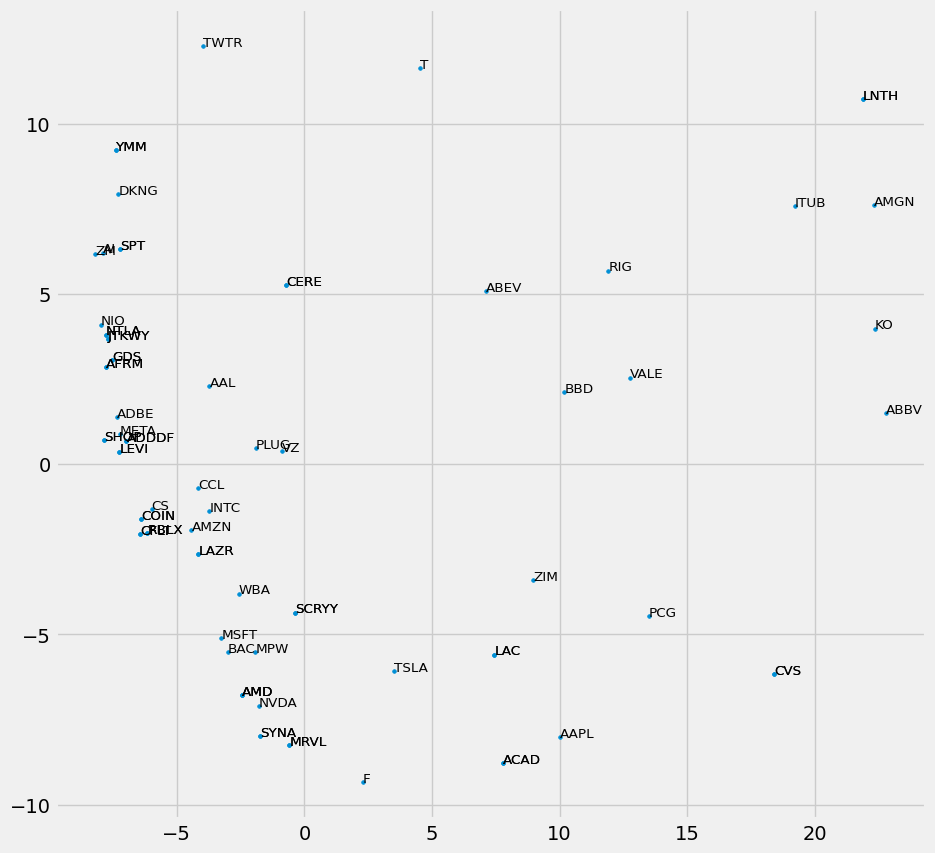

In [62]:
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=7)
for i, name in enumerate(data_scaled_df.index):
  plt.text(X_reduced[i][0], X_reduced[i][1], name, fontsize='x-small') 
plt.show()

Попробуем другой вывод визуализации:

In [77]:
kmeanModel_tsfel = KMeans(n_clusters=4)
kmeanModel_tsfel.fit(data_scaled_df)

KMeans(n_clusters=4)

In [78]:
KMeans(n_clusters=4)

KMeans(n_clusters=4)

In [79]:
clusters_tsfel = kmeanModel_tsfel.predict(data_scaled_df)

In [80]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled_df)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_tsfel, columns=['Cluster'])], axis = 1)
finalDf.head(3)

,principal component 1,principal component 2,Cluster
0,-7.901745,6.213136,1
1,-8.190596,6.167343,1
2,22.307837,7.598261,2


In [81]:
def plot_pca(finalDf):
  fig = plt.figure(figsize = (8,6))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)
  targets = [0, 1, 2, 3]
  colors = ['r', 'g', 'b', 'k']
  for target, color in zip(targets,colors):
      indicesToKeep = finalDf['Cluster'] == target
      ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
  ax.legend(targets)
  ax.grid()

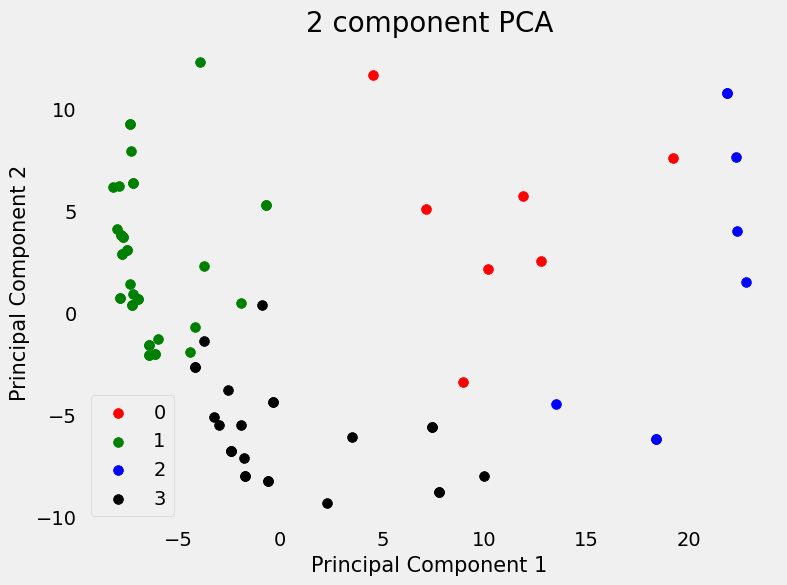

In [82]:
plot_pca(finalDf)

Кластеры визуально различимы 